### Simpl: Credit card approval and Credit limit prediction - developed by 'Harish Visweswaraiya'

In [1]:
from IPython.core.display import display, HTML   #resize window
display(HTML("<style>.container { width:100% !important; }</style>"))

## Step1: Import Libraries, create some useful functions and read data

In [2]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date

import gc
gc.enable()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from pycaret.classification import *

import time
import warnings
warnings.simplefilter('ignore', UserWarning)

#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 4000)

In [3]:
#Function to check % of missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

#Function to change the dataframe memory/size to optimal value
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [4]:
#Read data and optimize data types 
df = pd.read_csv('./simpl_payments_bank_digicard_v1.0.csv')
df = reduce_mem_usage(df, verbose=True)

Memory usage of dataframe: 7.25 MB
Memory usage after optimization: 5.22 MB
Decreased by 28.0%


## Step2 : Basic Feature Engineering (FE) and missing value imputation


### 2.1 Some demographics related FE would be helpful to understand the customers
    1. Calc age from dob
    2. Extract State from address
    3. Extract email domain, say private, to see if it has any importance 

In [5]:
## Demographics feature engg
def calculate_age(born):
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df['age'] = df['date_of_birth'].apply(calculate_age)

df1 = df.copy()
df1['address_new'] = [x.strip()[-8:] for x in df1['address']]
df1 = pd.concat([df1['user_id'], df1['address_new'].str.split(' ', expand=True)], axis=1)
df1.columns = ['user_id', 'address_State','address_Zip']
df = pd.merge(df, df1, on=['user_id'])
del df1

df['email_domain'] = df['email'].str.split('@').str[1]
df['private_email_domain'] = np.where(df.email_domain.isin(['gmail.com','yahoo.com','hotmail.com']),'Y','N')

# Drop unwanted fields
df.drop(['user_id','date_of_birth','address','email','email_domain','address_Zip','education_num'], axis=1, inplace=True)

### 2.2 Impute missing values

In [6]:
#Missing value imputation & data type conv
df.asset_class_cd.fillna('Unk', inplace=True)
df.asset_code.fillna(0, inplace=True)
df.asset_code= df.asset_code.astype(int).astype('str')
df['portfolio_type'].fillna(df['portfolio_type'].mode()[0], inplace=True)
df.inquiry_purpose_code.fillna(99, inplace=True)
df.inquiry_purpose_code = df.inquiry_purpose_code.astype(int).astype('str')
df.account_type = df.account_type.astype(int).astype('str')

In [7]:
missing_values_table(df)

,Missing Values,% of Total Values
gender,0,0.0
workclass,0,0.0
education_level,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
capital_gain,0,0.0
capital_loss,0,0.0
hours_per_week,0,0.0
approved,0,0.0


## Step3: Exploratory Data Analysis


### 3.1 Split the dataframe into numerical and categorical for easier EDA

In [8]:
#Filter columns into numerical & categorical
df_num = df.select_dtypes(include=[np.number]) #Numbers which are categories must be verified
df_cat = df.select_dtypes(exclude=[np.number])
df_num_shape = df_num.shape 
print("There are {} numerical data points and {} features".format(*df_num_shape))
df_cat_shape = df_cat.shape 
print("There are {} categorical data points and {} features".format(*df_cat_shape))

#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
print('='*15)
print('Distinct categories in categorical variables')
print(dstnct_cnt_col)

#Binary Variables(1 or 2)
df_binary_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] <=2]
df_binary_col = df_binary_col.index.values.tolist()
df_binary = df_cat[df_binary_col]
#Nominal Variables(2+)
df_nominal_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] >2]
df_nominal_col = df_nominal_col.index.values.tolist()
df_nominal = df_cat[df_nominal_col]

There are 45222 numerical data points and 5 features
There are 45222 categorical data points and 14 features
Distinct categories in categorical variables
                      count
gender                    2
workclass                 7
education_level          16
marital_status            7
occupation               14
relationship              6
inquiry_purpose_code     18
institute_type           10
account_type             37
asset_class_cd            9
asset_code                5
portfolio_type            4
address_State            54
private_email_domain      2


### 3.2 EDA PLOTS - Univariate analysis

Target Distribution


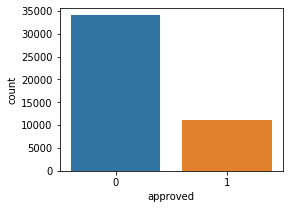

In [9]:
#EDA plots - 0
#Target distribution
print("Target Distribution")
print('='*15)
df_Y_col = df['approved'].index.values.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(4,3)
sns.countplot(x = df_Y_col, data=df['approved']);
plt.show()

Independent variables:
Distibution of Binary variables


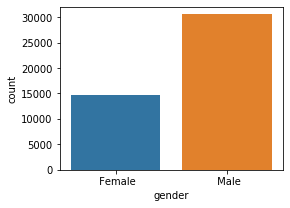

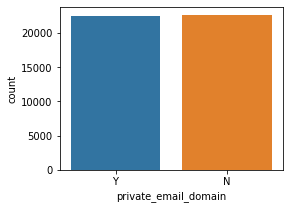

Distibution of Nominal variables


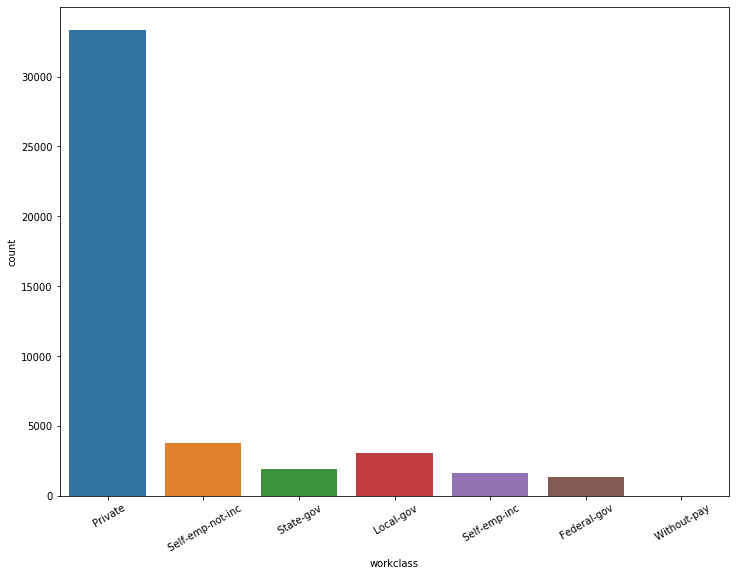

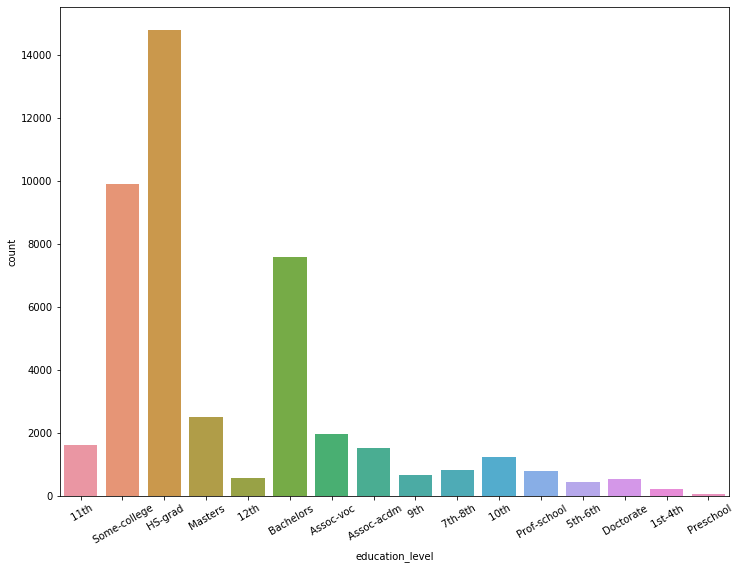

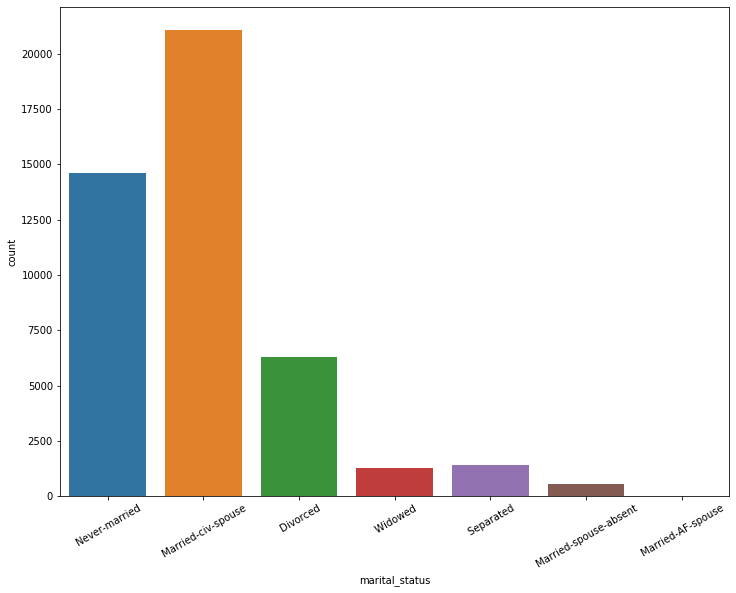

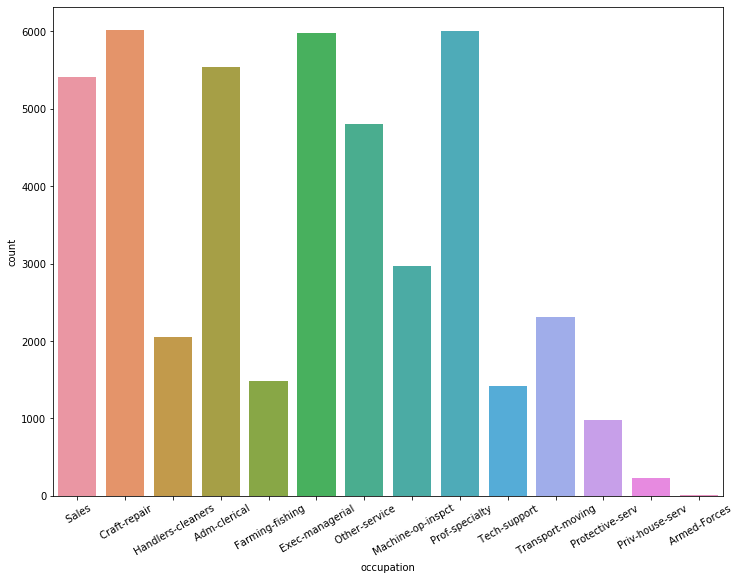

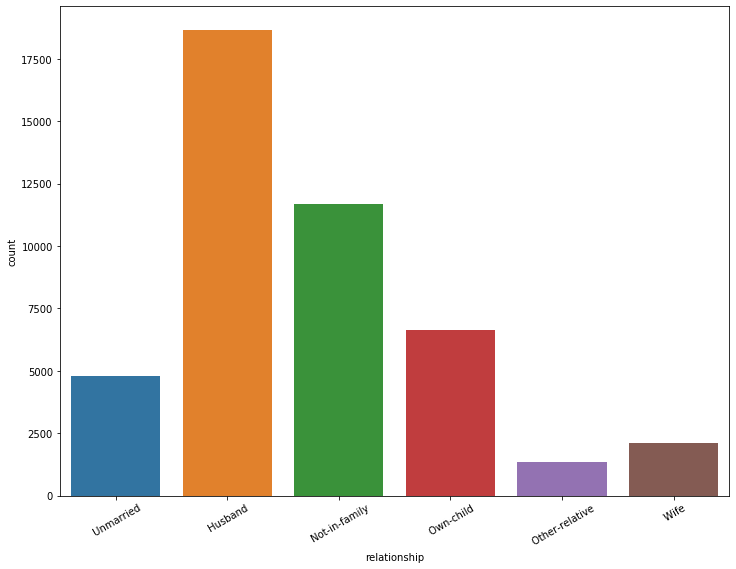

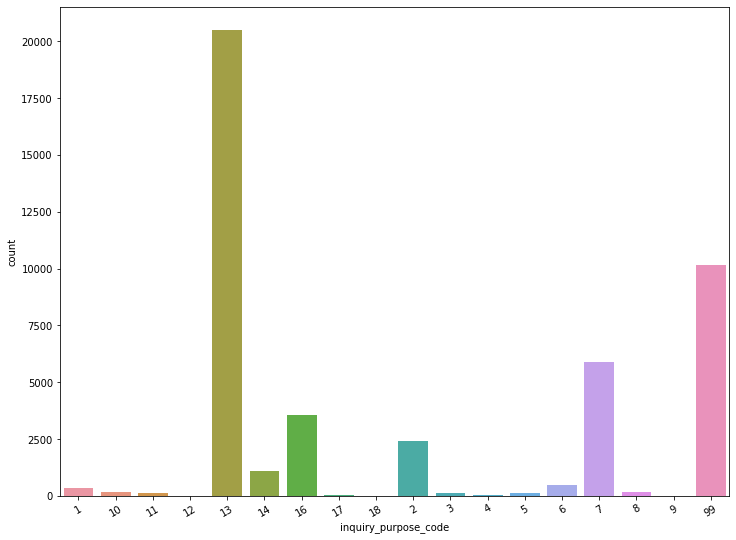

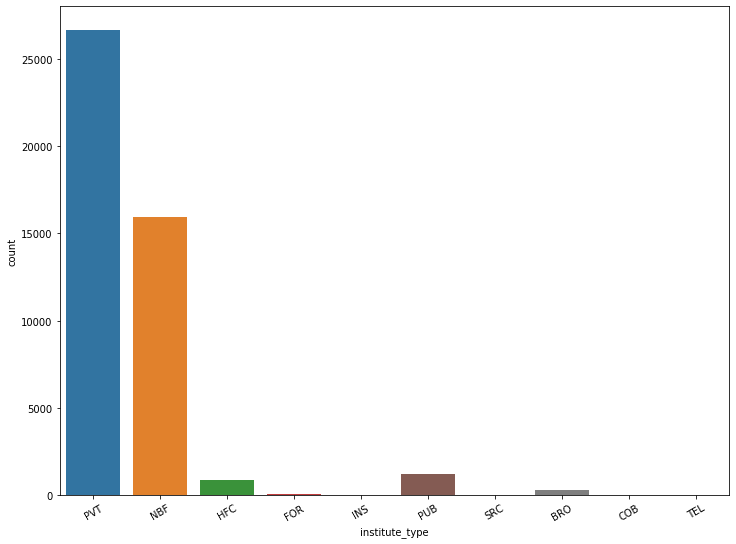

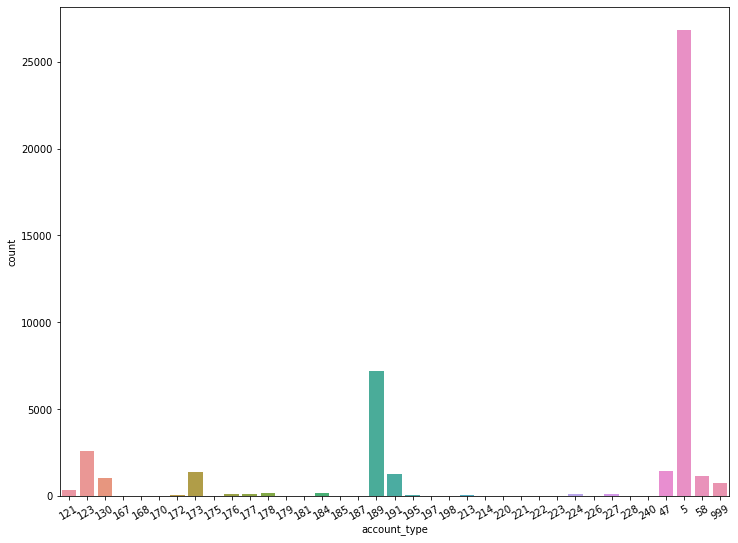

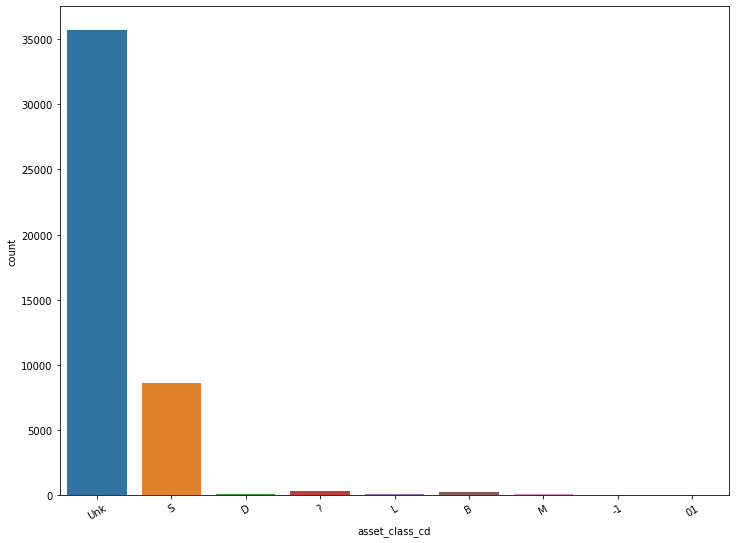

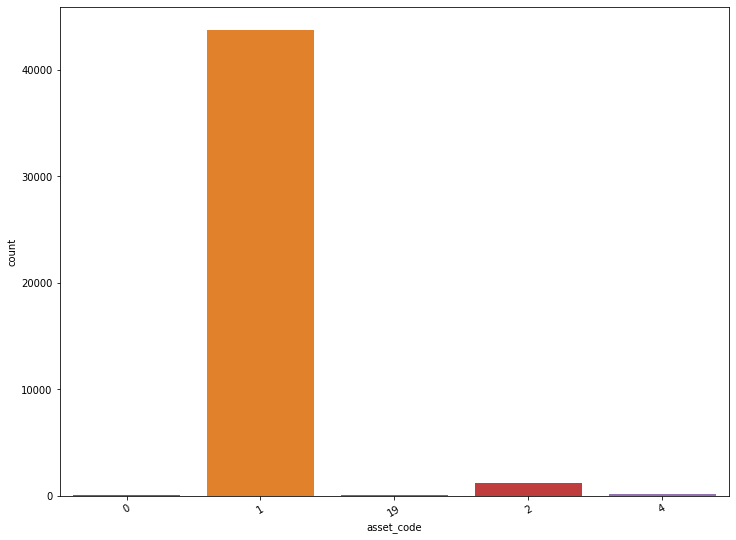

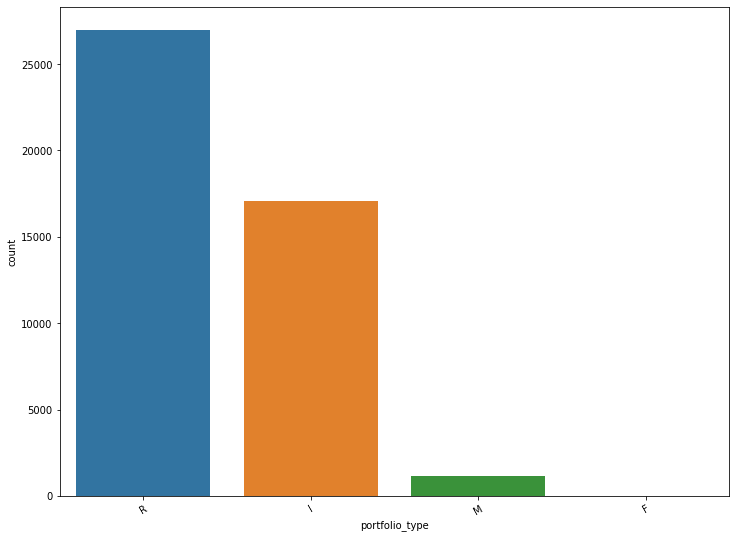

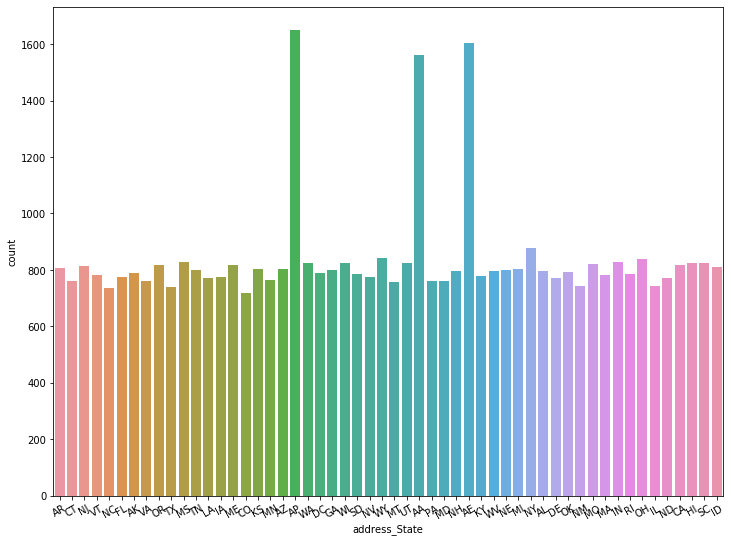

Distibution of Continuous variables


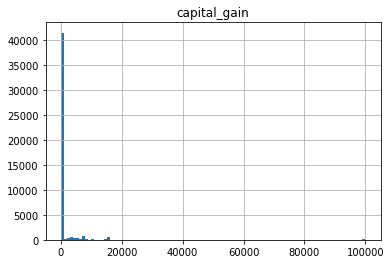

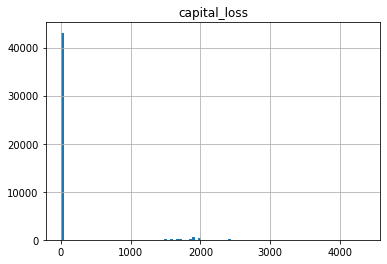

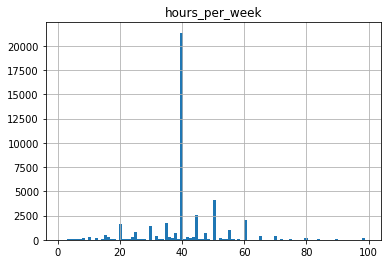

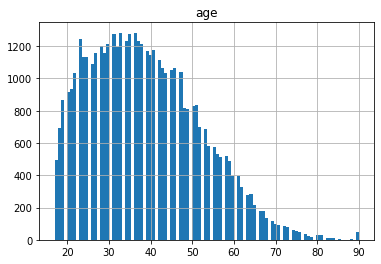

In [10]:
#EDA plots - 1 
#Univariate analysis - Checking distribution of binary variables
print("Independent variables:")
print('='*15)
print('Distibution of Binary variables')
print('='*15)
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(4,3)
    sns.countplot(x=i, data=df_cat);
    plt.show()
    
    
#EDA plots - 2 
#Univariate analysis - Checking distribution of nominal variables
print('Distibution of Nominal variables')
print('='*15)
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.xticks(rotation=30)
    plt.show()
    
    
#EDA plots - 3
#Univariate analysis - Checking distribution of numerical variables using histogram
print ('Distibution of Continuous variables')
print('='*15)
for i in [f for f in df_num.columns.tolist() if f != 'approved']:
    df_num.hist(column=i, bins = 100)
    plt.show()

### 3.3 EDA PLOTS - Bivariate analysis

Binary variables


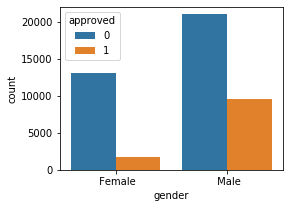

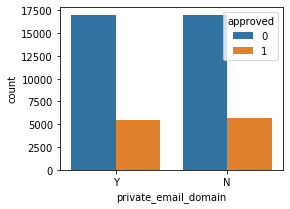

Nominal variables


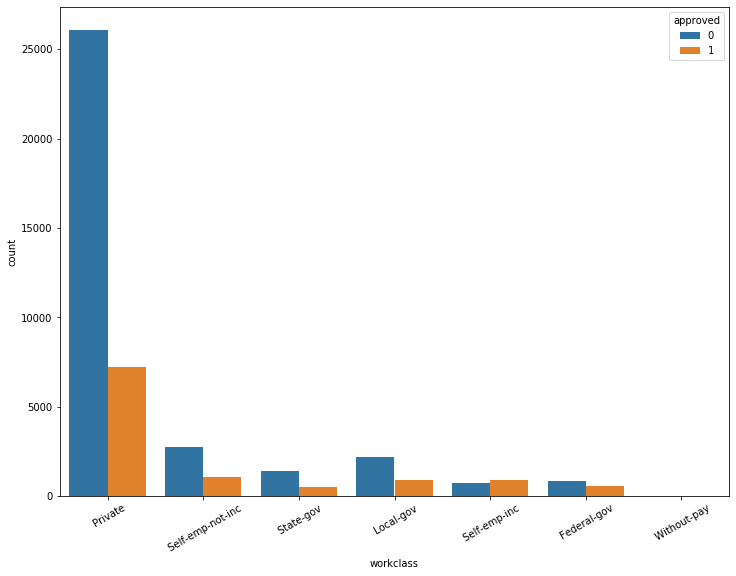

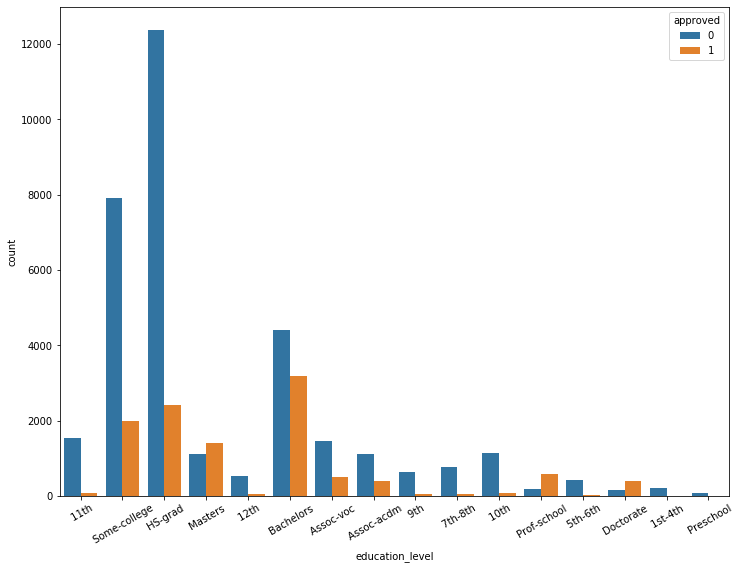

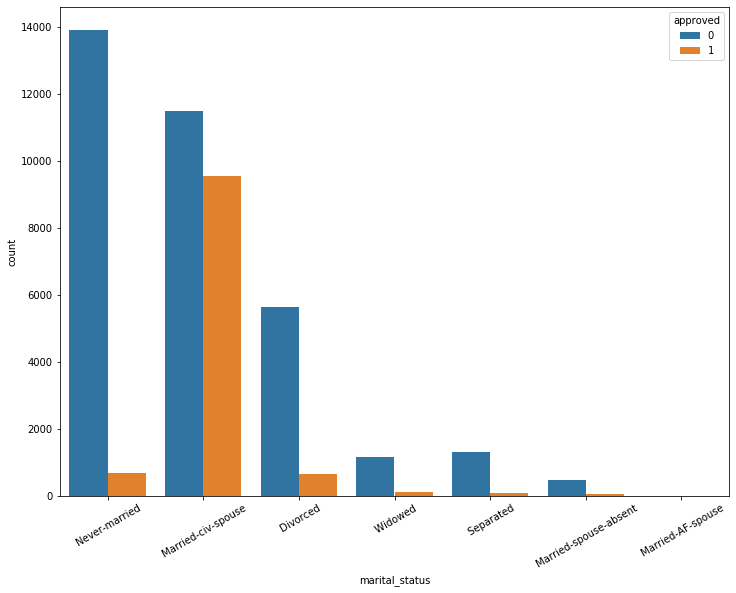

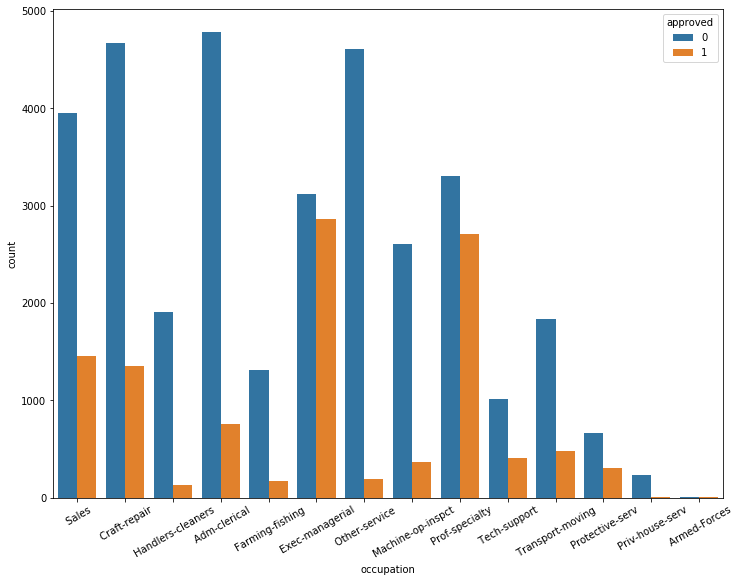

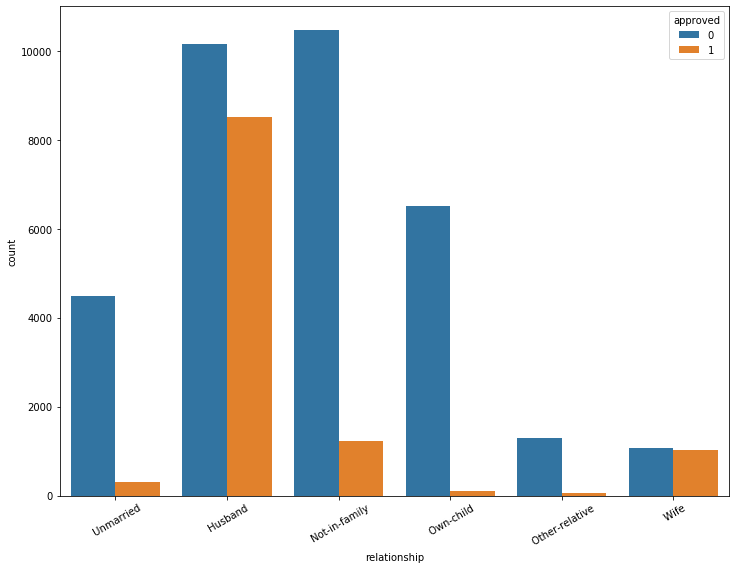

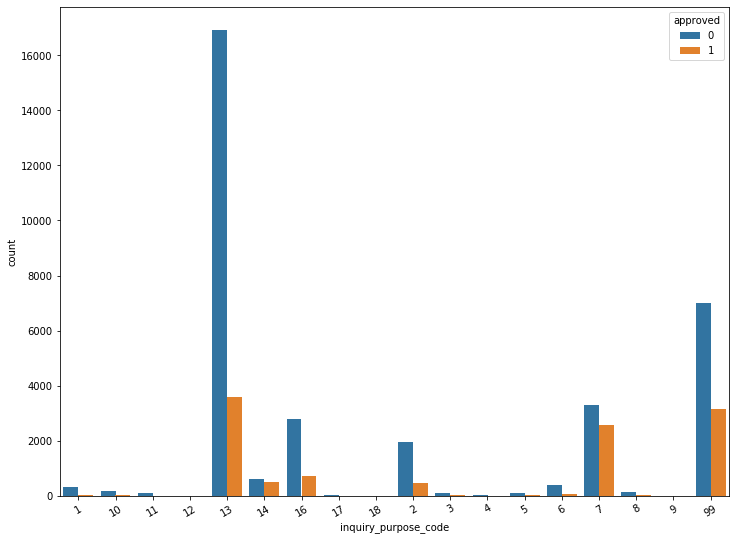

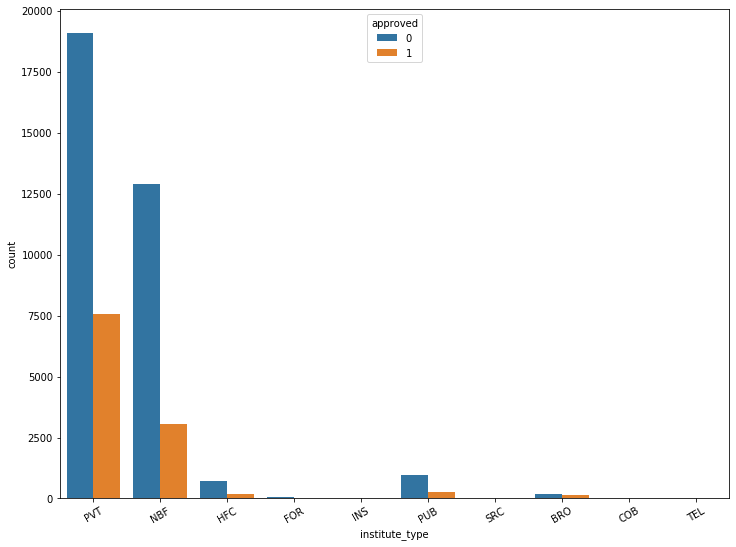

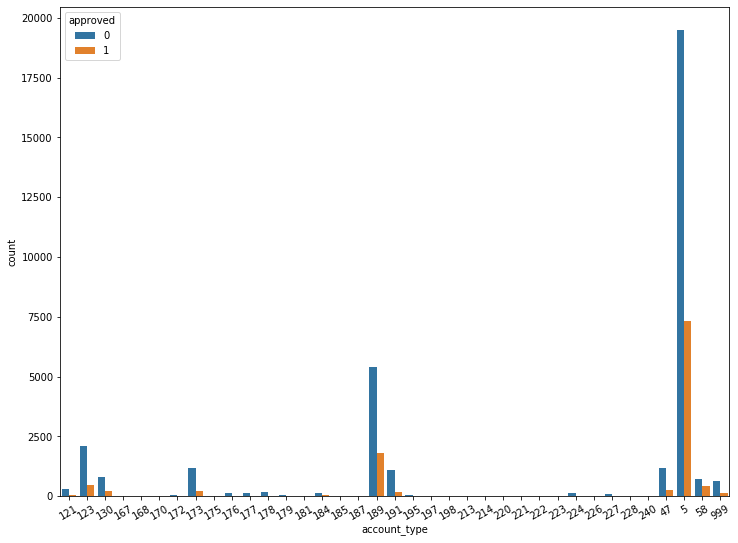

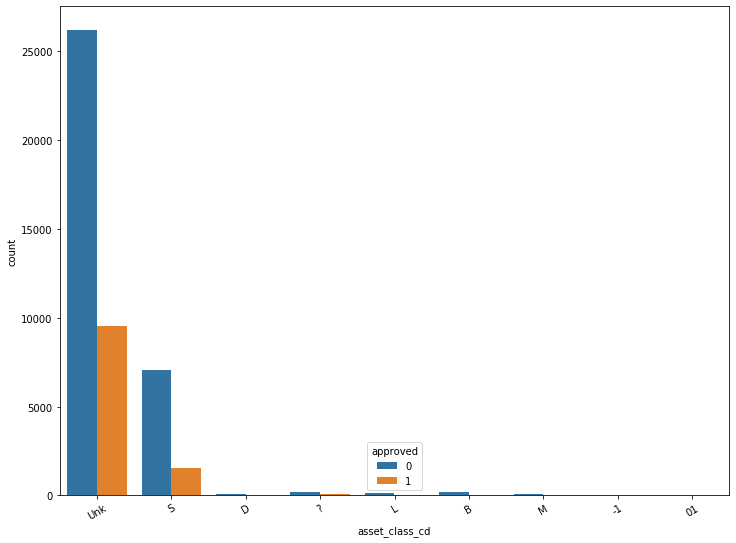

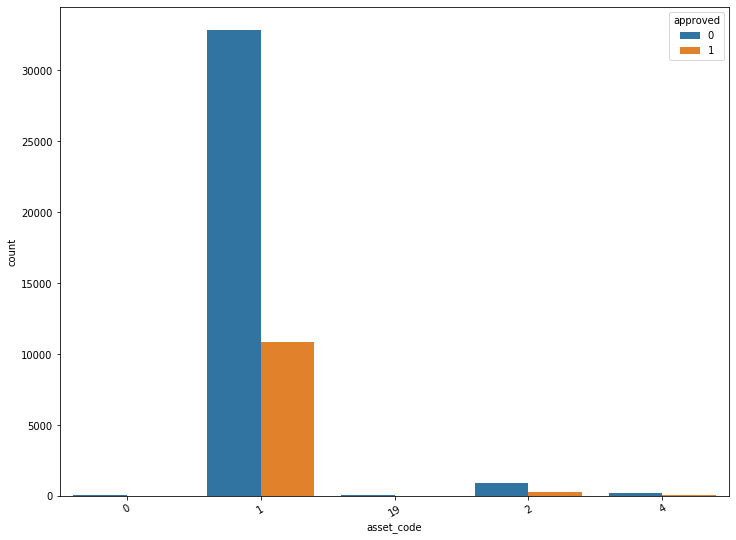

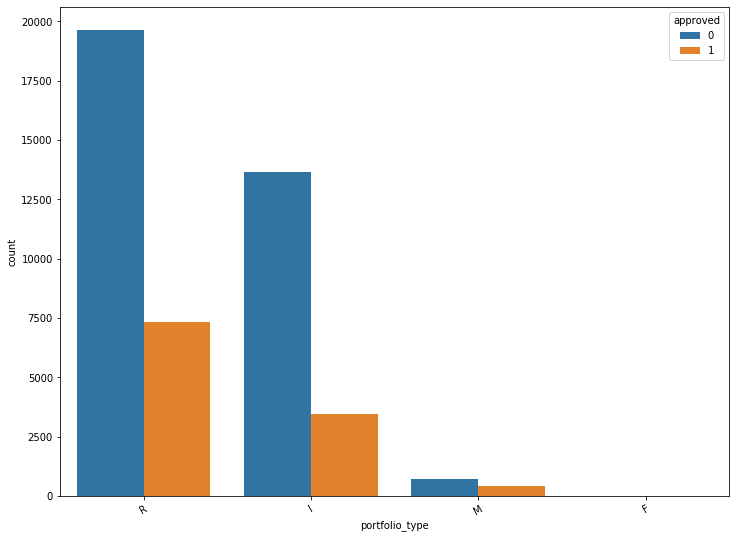

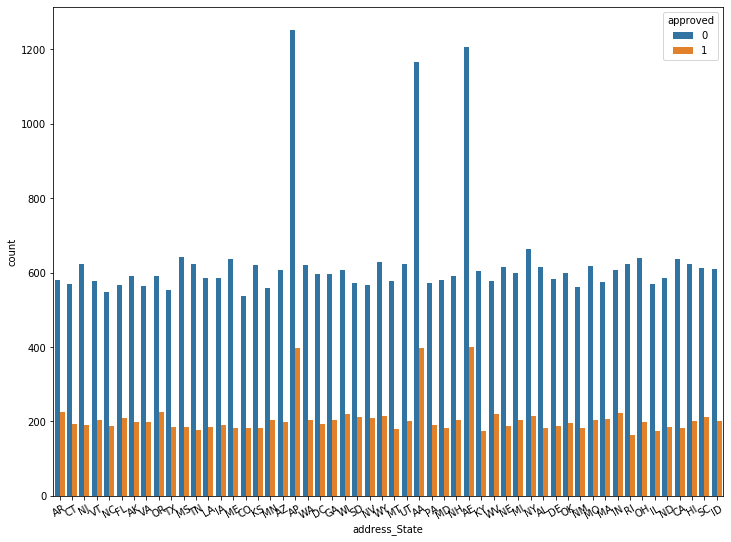

Density plots on Continous variables based on Target:


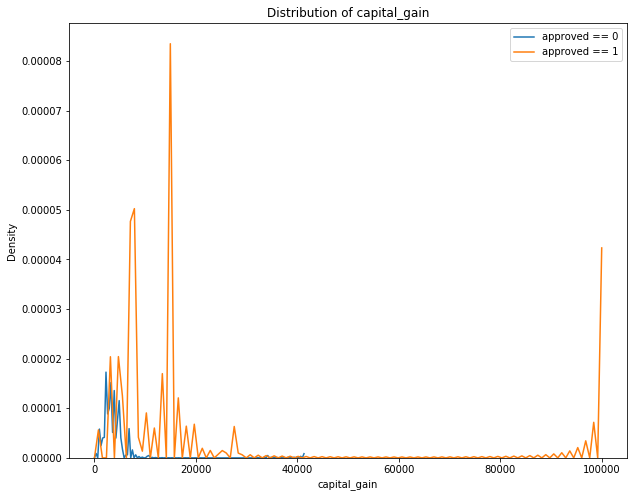

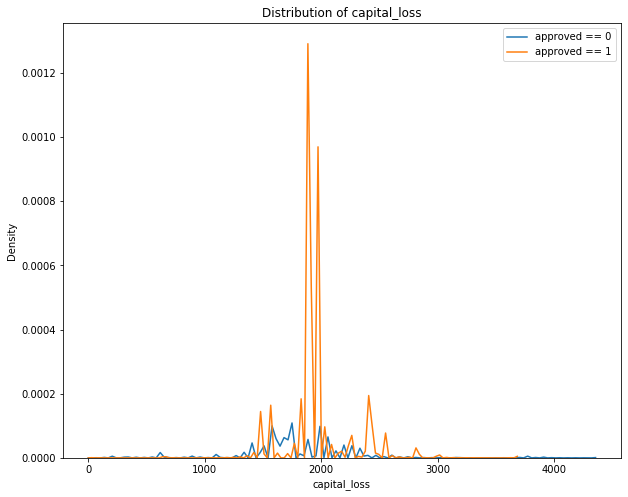

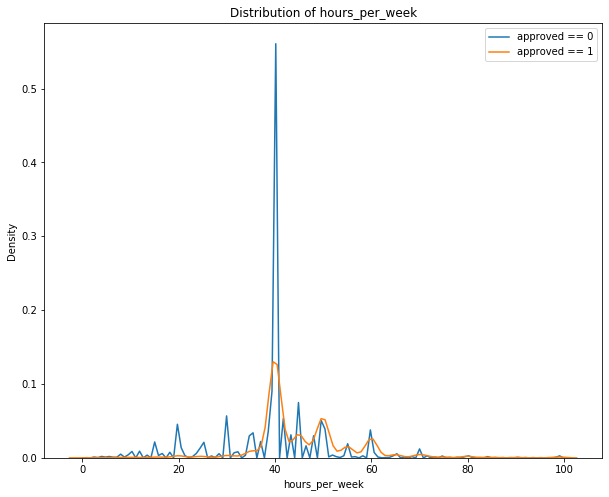

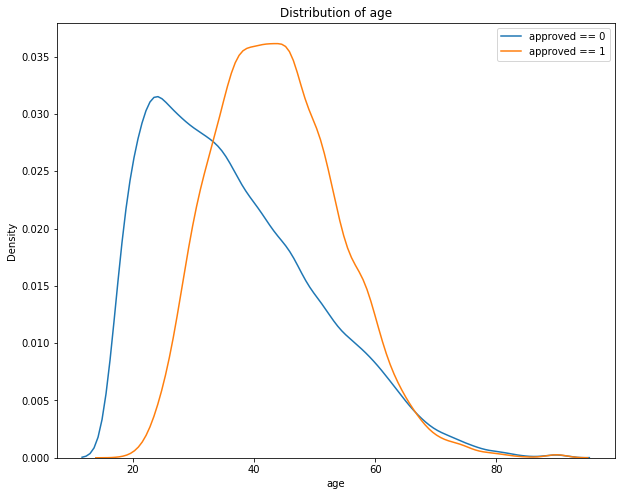

In [11]:
## Target based
#EDA - 4 Bi-variate analysis on binary variables
print("Binary variables")
print("="*15)
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 3)
    sns.countplot(x=i, data=df, hue='approved')
    plt.show()
    
#EDA - 5 Bi-variate analysis on nominal variables
print("Nominal variables")
print("="*15)
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='approved')
    plt.xticks(rotation=30)
    plt.show()

#EDA - 6 Bi-variate analysis on continuous variables
print("Density plots on Continous variables based on Target:")
print('='*15)
for i in [f for f in df_num.columns.tolist() if f != 'approved']:
    
    plt.figure(figsize = (10, 8))

    # KDE plot of credit cards that were approved
    sns.kdeplot(df.loc[df['approved'] == 0, i], label = 'approved == 0')

    # KDE plot of credit cards which were not approved
    sns.kdeplot(df.loc[df['approved'] == 1, i], label = 'approved == 1')

    # Labeling of plot
    plt.xlabel(i); plt.ylabel('Density'); plt.title('Distribution of '+i);

## Step4: Custom/Additional Feature Engineering
    1. Compute age as bins - Young, Middle-aged, Senior, Old
    2. Compute work hours as bins - PartTime, FullTime, OverTime, Workaholic
    3. Reduce education levels groups
    4. Reduce marital status groups
    5. Reduce relationship status (May be a redundant feature) groups
    6. Reduce occupation groups
    7. Reduce workclass groups
    8. Compute net capital
    9. Reduce inquiry purpose code groups
    10. Filter 'Credit Card' account type

In [12]:
#Creating bins of age
bins = [0,25,45,65,120]
df['age'] = pd.cut(df['age'],bins, labels=["Young", "Middle-aged", "Senior","Old"])
df['age'] = df['age'].astype('str')

#Creating bins of hours/week
bins = [0,25,40,60,120]
df['hours_per_week'] = pd.cut(df['hours_per_week'],bins, labels=["PartTime", "FullTime", "OverTime","Workaholic"])
df['hours_per_week'] = df['hours_per_week'].astype('str')

#Group Education Level
df['education_level'] = df['education_level'].str.strip()
df['education_level'] = np.where(df.education_level.isin(['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th']), 'School-Dropout', df.education_level)
df['education_level'] = np.where(df.education_level.isin(['HS-grad','Some-college']), 'HS-Graduate', df.education_level)
df['education_level'] = np.where(df.education_level.isin(['Assoc-acdm','Assoc-voc']), 'Associates', df.education_level)

#Marital Status
df['marital_status'] = df['marital_status'].str.strip()
df['marital_status'] = np.where(df.marital_status.isin(['Married-AF-spouse','Married-civ-spouse']), 'Married', df.marital_status)
df['marital_status'] = np.where(df.marital_status.isin(['Married-spouse-absent','Separated','Divorced','Widowed']), 'Not-married', df.marital_status)

#Relationship
df['relationship'] = df['relationship'].str.strip()
df['relationship'] = np.where(df.relationship.isin(['Unmarried','Not-in-family']), 'Single', df.relationship)
df['relationship'] = np.where(df.relationship.isin(['Husband','Wife']), 'Has-Spouse', df.relationship)

#Occupation
df['occupation'] = df['occupation'].str.strip()
df['occupation'] = np.where(df.occupation.isin(['Adm-clerical']), 'Admin', df.occupation)
df['occupation'] = np.where(df.occupation.isin(['Armed-Forces','Protective-serv']), 'Protective-services', df.occupation)
df['occupation'] = np.where(df.occupation.isin(['Craft-repair','Farming-fishing','Handlers-cleaners','Machine-op-inspct','Transport-moving']), 'Blue-Collar', df.occupation)
df['occupation'] = np.where(df.occupation.isin(['Exec-managerial','Prof-specialty']), 'Professional-Specialty ', df.occupation)
df['occupation'] = np.where(df.occupation.isin(['Other-service','Priv-house-serv']), 'Other-services', df.occupation)

#workclass
df['workclass'] = df['workclass'].str.strip()
df['workclass'] = np.where(df.workclass.isin(['Local-gov','State-gov','Federal-gov']), 'Government', df.workclass)

#Net capital
df['net_capital'] = df.capital_gain - df.capital_loss
df['net_capital_bin'] = np.where(df.net_capital<0, 'Negative', df.net_capital)
df['net_capital_bin'] = np.where(df.net_capital==0, 'None', df.net_capital_bin)
df['net_capital_bin'] = np.where((df.net_capital>0), 'Positive', df.net_capital_bin)

#Inquiry_purpose_code
df['inquiry_purpose_code'] = df['inquiry_purpose_code'].str.strip()
df['inquiry_purpose_code'] = np.where(df.inquiry_purpose_code.isin(['2','16']), 'Vehicle Loan', df.inquiry_purpose_code)
df['inquiry_purpose_code'] = np.where(df.inquiry_purpose_code.isin(['7','19']), 'Credit Card', df.inquiry_purpose_code)
df['inquiry_purpose_code'] = np.where(df.inquiry_purpose_code == '13', 'Personal Loan', df.inquiry_purpose_code)
df['inquiry_purpose_code'] = np.where(df.inquiry_purpose_code == '14', 'Property Loan', df.inquiry_purpose_code)
df['inquiry_purpose_code'] = np.where(~df.inquiry_purpose_code.isin(['Vehicle Loan','Credit Card','Personal Loan','Property Loan']), 'Others', df.inquiry_purpose_code)

#Account_Type
df['account_type'] = np.where(df.account_type == '5', 'Credit Card', 'Others')

# Drop unwanted fields
df.drop(['net_capital'], axis=1, inplace=True)

## Step5 : Repeat Step3 to see the influence of Step4

## Step6: Credit Card Approval - Model training and interpretation using pycaret

### 6.1 Environment Setup

In [13]:
num_cols = ['capital_gain', 'capital_loss']
cat_cols = ['gender', 'workclass', 'education_level', 'marital_status', 'occupation', 'relationship','inquiry_purpose_code',
            'institute_type','account_type','asset_class_cd','asset_code','portfolio_type','address_State',
            'private_email_domain']
ignore_cols = ['address_State']

clf1 = setup(df, target = 'approved', session_id=786, categorical_features=cat_cols, ignore_features=ignore_cols,
            numeric_features=num_cols, silent=True)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,786
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(45222, 20)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,17
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


### 6.2 Compare different models
    Cross Validation: Pycaret models are trained on 70/30 (train/test) split with 10 fold CV on training data
    Metric: Target data is fairly balanced(~25%). So a good metric would generally be AUC/F-1 score

In [14]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8715,0.9306,0.6633,0.7851,0.7189,0.6364
1,Light Gradient Boosting Machine,0.8703,0.9291,0.6597,0.7829,0.7159,0.6327
2,Gradient Boosting Classifier,0.8637,0.9203,0.6131,0.7902,0.6903,0.6047
3,Extreme Gradient Boosting,0.863,0.9193,0.6043,0.7939,0.686,0.6005
4,Ada Boost Classifier,0.8602,0.9157,0.6362,0.7605,0.6928,0.6032
5,K Neighbors Classifier,0.8523,0.8866,0.6463,0.7277,0.6845,0.5886
6,Logistic Regression,0.851,0.9054,0.6068,0.7452,0.6687,0.5739
7,Linear Discriminant Analysis,0.8454,0.9002,0.5942,0.7318,0.6557,0.5574
8,Ridge Classifier,0.8453,0,0.5542,0.7565,0.6396,0.5441
9,Random Forest Classifier,0.8396,0.8753,0.599,0.7086,0.649,0.546


### 6.3 Model Results Interpretation
#### We could notice that LightGBM & CatBoost are giving similar prediction results. I chose both for model interpretation

#### 6.3.1 Model creation

In [15]:
lightgbm = create_model('lightgbm', verbose=False)
catboost = create_model('catboost', verbose=False)
# xgboost = create_model('xgboost', verbose=False)
# nb = create_model('nb', verbose=False)
# blender = blend_models(estimator_list=[nb,lightgbm,xgboost], method = 'soft')
# blender.estimators_

#### 6.3.2 Click on any plot type for further analysis

In [16]:
evaluate_model(lightgbm) #doesn't work for catboost

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### 6.3.3 Model interpretation - SHAP based interpretation works for any tree based ML model
    1. LightGBM
    2. CatBoost

SHAP interpretation - lightgbm
Global feature importance - lightgbm
---------------


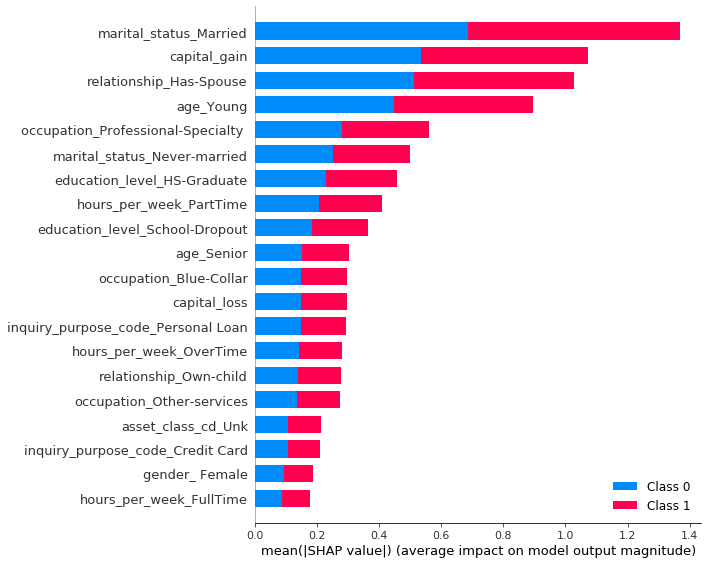

Feature Interaction & Correlation - lightgbm
---------------


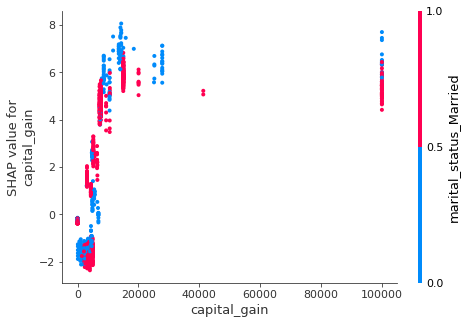

Local interpretation - lightgbm
---------------


In [17]:
model = lightgbm
model_name = 'lightgbm'
print("SHAP interpretation - "+model_name)
print("="*15)
print("Global feature importance - "+model_name)
print("-"*15)
interpret_model(model)
print("Feature Interaction & Correlation - "+model_name)
print("-"*15)
interpret_model(model, plot = 'correlation')
print("Local interpretation - "+model_name)
print("-"*15)
interpret_model(model, plot = 'reason', observation=1)

SHAP interpretation - catboost
Global feature importance - catboost
---------------


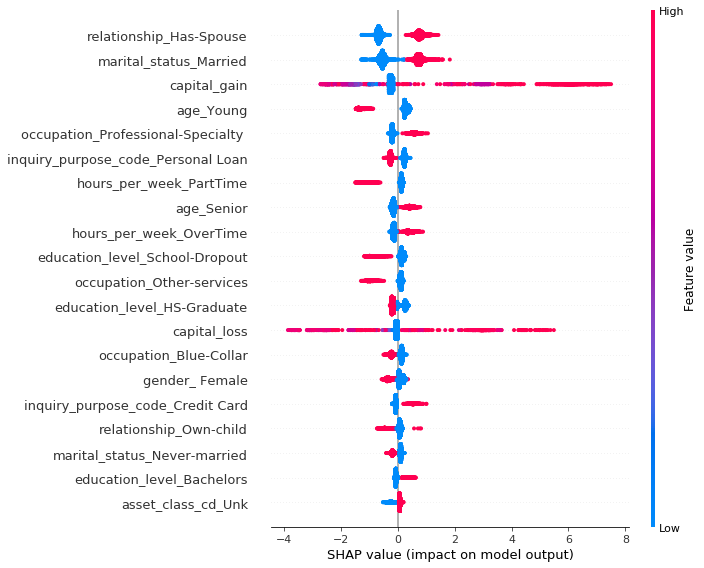

Feature Interaction & Correlation - catboost
---------------


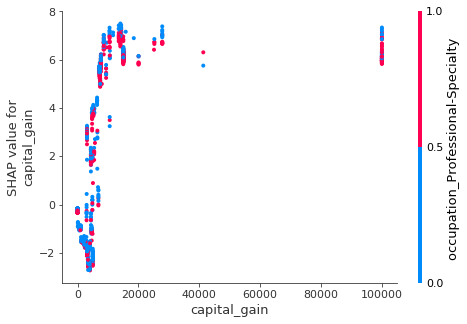

Local interpretation - catboost
---------------


In [18]:
model = catboost
model_name = 'catboost'
print("SHAP interpretation - "+model_name)
print("="*15)
print("Global feature importance - "+model_name)
print("-"*15)
interpret_model(model)
print("Feature Interaction & Correlation - "+model_name)
print("-"*15)
interpret_model(model, plot = 'correlation')
print("Local interpretation - "+model_name)
print("-"*15)
interpret_model(model, plot = 'reason', observation=1)

### Top 3 predictors:
### Capital Gain and one-hot encoded variables - In Relationship, Has_Spouse(or not) and in Marital_Status, Married (or not) 

## Step7: Save, Load model (as pickle) and Predict using Pycaret
    Holdout test data - 30% of original data
    LightGBM gives 93.9% AUC and 73.2% F1 score
    CatBoost gives 94.5% AUC and 75.2% F1 score

In [19]:
# Save, load and predict using pycaret 
final_lightgbm = finalize_model(lightgbm)
save_model(final_lightgbm, 'ABC_Bank_cc_lightgbm')
final_lightgbm = load_model('ABC_Bank_cc_lightgbm')

# Predict using pycaret
predictions_lightgbm = predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Light Gradient Boosting Machine,0.8773,0.9386,0.6743,0.7991,0.7314,0.6526


In [20]:
# Save, load and predict using pycaret 
final_catboost = finalize_model(catboost)
save_model(final_catboost, 'ABC_Bank_cc_catboost')
final_catboost = load_model('ABC_Bank_cc_catboost')

# Predict using pycaret
predictions_catboost = predict_model(final_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.8865,0.9446,0.6933,0.8208,0.7517,0.6788


### Verdict: CatBoost trumps LightGBM for credit card approval prediction
    'Label' variable in predictions_catboost dataframe gives approval predictions

## Step8: Estimate the credit limit for card approved Customers

### Prerequisite for credit limit - credit card approval. ABC Bank is willing to give credit limit between 1k - 8k USD.

### Some of the commonly used factors that determine credit limit are:
    1. Income
    2. Debt-to-Income Ratio
    3. Interest Rate
    4. Credit History
    5. Limits on other credit cards
    
Source: https://www.thebalance.com/how-credit-limits-are-determined-4117390

### 8.1 Filter credit card approved customers in test data predictions

In [21]:
predictions_catboost.Label.value_counts()

cc_approved = predictions_catboost[predictions_catboost.Label == 1]

### 8.2 Prediction Probability distribution

In [22]:
cc_approved.Score.describe()

count    2840.000000
mean        0.797378
std         0.170835
min         0.500000
25%         0.634400
50%         0.809550
75%         0.985325
max         0.999800
Name: Score, dtype: float64

### 8.3 Scaling probabilities to credit limit
    Since the input data is missing important factors listed in Step 8, a simple scaling function is used to transform probabilities to credit limit. 
    Scaling function can be customized based on other features too - like Income, Debt-to-Income Ratio

In [23]:
def scale_number(unscaled, to_min, to_max, from_min, from_max):
    return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

def scale_list(l, to_min, to_max):
    return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

cc_approved['Scaled_Score'] = scale_list(cc_approved.Score.values.tolist(), 1000, 8000)
decimals = -1    
cc_approved['Scaled_Score'] = cc_approved['Scaled_Score'].apply(lambda x: round(x, decimals))

cc_approved['Scaled_Score'].describe()

count    2840.000000
mean     5164.802817
std      2392.464916
min      1000.000000
25%      2880.000000
50%      5335.000000
75%      7800.000000
max      8000.000000
Name: Scaled_Score, dtype: float64

### It could be noted that credit limit is nicely scaled(& rounded) to 1k to 8k USD based on credit card approval probabilities